In [26]:
import json
import os
import numpy as np
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, roc_curve
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [27]:
SAVE_PATH = '/home/ec2-user/work/final_artifacts'
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [28]:
SEED = 0
BATCH_SIZE = 32
HEIGHT, WIDTH = 256, 256

---
### Segmentation model

In [29]:
# https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/
data_dir = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")
print("Path to dataset files:", data_dir)

Path to dataset files: /home/ec2-user/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2


In [30]:
masks, images = [], []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file = os.path.join(root, file)
        if file.endswith('.tif'):
            if file.split('_')[-1] == 'mask.tif':
                masks.append(file)
            else:
                images.append(file)
del root, dirs, files, file, data_dir

In [31]:
image_keys = [f.split('/')[-1].rstrip('.tif') for f in images]
mask_dict = {f.split('/')[-1].rstrip('_mask.tif'): f for f in masks}
masks = [mask_dict[k] for k in image_keys]

df = pd.DataFrame({'images': images, 'masks': masks})

del masks, images, image_keys, mask_dict

In [32]:
df_train_seg, df_test_seg = train_test_split(
    df, train_size=3500, shuffle=True, random_state=SEED
)
df_train_seg, df_val_seg = train_test_split(
    df_train_seg, train_size=3000, shuffle=True, random_state=SEED
)
del df

In [8]:
def datagen_seg(df):
    image_gen = ImageDataGenerator(
        rotation_range=0.,
        width_shift_range=0.,
        height_shift_range=0.,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        horizontal_flip=False,
        vertical_flip=False,
        validation_split=0.,
        rescale=1/255,
        fill_mode='constant',
        cval=0.,
    ).flow_from_dataframe(
        df,
        x_col='images',
        class_mode=None,
        color_mode='rgb',
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED,
    )
    mask_gen = ImageDataGenerator(
        validation_split=0.,
        rescale=1/255,
        fill_mode='constant',
        cval=0.,
    ).flow_from_dataframe(
        df,
        x_col='masks',
        class_mode=None,
        color_mode='grayscale',
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED,
    )
    for image, mask in zip(image_gen, mask_gen):
        mask = mask.astype(int)
        counts = np.array([ (mask==0).sum(), (mask==1).sum() ])
        weights = mask.size / (2 * counts)
        weight_mask = weights[mask]
        yield image, mask, weight_mask


In [9]:
train_datagen_seg = datagen_seg(df_train_seg)
val_datagen_seg = datagen_seg(df_val_seg)
test_datagen_seg = datagen_seg(df_test_seg)

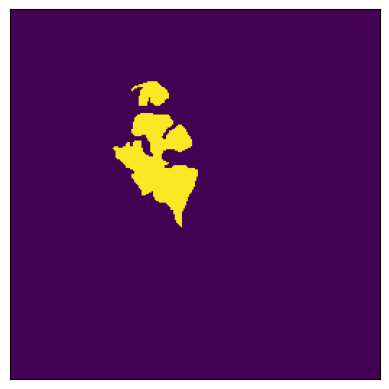

In [25]:
# imgs = next(iter(train_datagen_seg))

i = 3
# plt.imshow(imgs[0][i])
plt.imshow(imgs[1][i], alpha=1)
# plt.title(imgs[1][i].sum())
plt.xticks([])
plt.yticks([])
plt.show()

# del imgs

Found 3000 validated image filenames.
Found 3000 validated image filenames.


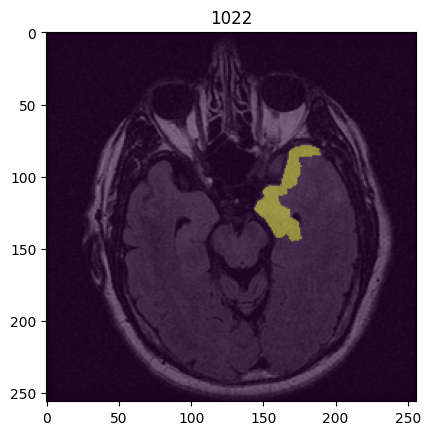

In [ ]:
imgs = next(iter(train_datagen_seg))

i = 27
plt.imshow(imgs[0][i])
plt.imshow(imgs[1][i], alpha=0.4)
plt.title(imgs[1][i].sum())
plt.show()

del imgs

In [ ]:
# # https://www.kaggle.com/code/abdelrasoul/brain-tumor-u-net

# def unet(input_size=(256, 256, 3)):

#     # Input
#     inputs = Input(input_size)

#     # Encoder 1
#     conv1 = Conv2D(64, (3, 3), padding="same")(inputs)
#     bn1 = Activation("relu")(conv1)
#     conv1 = Conv2D(64, (3, 3), padding="same")(bn1)
#     bn1 = BatchNormalization(axis=3)(conv1)
#     bn1 = Activation("relu")(bn1)
#     pool1 = MaxPooling2D((2, 2))(bn1)

#     # Encoder 2
#     conv2 = Conv2D(128, (3, 3), padding="same")(pool1)
#     bn2 = Activation("relu")(conv2)
#     conv2 = Conv2D(128, (3, 3), padding="same")(bn2)
#     bn2 = BatchNormalization(axis=3)(conv2)
#     bn2 = Activation("relu")(bn2)
#     pool2 = MaxPooling2D((2, 2))(bn2)

#     # Encoder 3
#     conv3 = Conv2D(256, (3, 3), padding="same")(pool2)
#     bn3 = Activation("relu")(conv3)
#     conv3 = Conv2D(256, (3, 3), padding="same")(bn3)
#     bn3 = BatchNormalization(axis=3)(conv3)
#     bn3 = Activation("relu")(bn3)
#     pool3 = MaxPooling2D((2, 2))(bn3)

#     # Encoder 4
#     conv4 = Conv2D(512, (3, 3), padding="same")(pool3)
#     bn4 = Activation("relu")(conv4)
#     conv4 = Conv2D(512, (3, 3), padding="same")(bn4)
#     bn4 = BatchNormalization(axis=3)(conv4)
#     bn4 = Activation("relu")(bn4)
#     pool4 = MaxPooling2D((2, 2))(bn4)

#     # Bottleneck
#     conv5 = Conv2D(1024, (3, 3), padding="same")(pool4)
#     bn5 = Activation("relu")(conv5)
#     conv5 = Conv2D(1024, (3, 3), padding="same")(bn5)
#     bn5 = BatchNormalization(axis=3)(conv5)
#     bn5 = Activation("relu")(bn5)

#     # Decoder 4
#     up6 = UpSampling2D((2, 2))(bn5)
#     up6 = concatenate([up6, bn4])
#     conv6 = Conv2D(512, (3, 3), padding="same")(up6)
#     bn6 = Activation("relu")(conv6)
#     conv6 = Conv2D(512, (3, 3), padding="same")(bn6)
#     bn6 = BatchNormalization(axis=3)(conv6)
#     bn6 = Activation("relu")(bn6)

#     # Decoder 3
#     up7 = UpSampling2D((2, 2))(bn6)
#     up7 = concatenate([up7, bn3])
#     conv7 = Conv2D(256, (3, 3), padding="same")(up7)
#     bn7 = Activation("relu")(conv7)
#     conv7 = Conv2D(256, (3, 3), padding="same")(bn7)
#     bn7 = BatchNormalization(axis=3)(conv7)
#     bn7 = Activation("relu")(bn7)

#     # Decoder 2
#     up8 = UpSampling2D((2, 2))(bn7)
#     up8 = concatenate([up8, bn2])
#     conv8 = Conv2D(128, (3, 3), padding="same")(up8)
#     bn8 = Activation("relu")(conv8)
#     conv8 = Conv2D(128, (3, 3), padding="same")(bn8)
#     bn8 = BatchNormalization(axis=3)(conv8)
#     bn8 = Activation("relu")(bn8)

#     # Decoder 1
#     up9 = UpSampling2D((2, 2))(bn8)
#     up9 = concatenate([up9, bn1])
#     conv9 = Conv2D(64, (3, 3), padding="same")(up9)
#     bn9 = Activation("relu")(conv9)
#     conv9 = Conv2D(64, (3, 3), padding="same")(bn9)
#     bn9 = BatchNormalization(axis=3)(conv9)
#     bn9 = Activation("relu")(bn9)

#     # Output
#     outputs = Conv2D(1, (1, 1))(bn9)

#     return Model(inputs, outputs)

In [ ]:
def unet(input_size=(256, 256, 3)):

    # Input
    inputs = Input(input_size)

    # Encoder 1
    conv1 = Conv2D(64, (3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(64, (3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D((2, 2))(bn1)

    # Encoder 2
    conv2 = Conv2D(128, (3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(128, (3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D((2, 2))(bn2)

    # Encoder 3
    conv3 = Conv2D(256, (3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(256, (3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D((2, 2))(bn3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(512, (3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)

    # Decoder 3
    up5 = UpSampling2D((2, 2))(bn4)
    up5 = concatenate([up5, bn3])
    conv5 = Conv2D(256, (3, 3), padding="same")(up5)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(256, (3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    # Decoder 2
    up6 = UpSampling2D((2, 2))(bn5)
    up6 = concatenate([up6, bn2])
    conv6 = Conv2D(128, (3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(128, (3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    # Decoder 1
    up7 = UpSampling2D((2, 2))(bn6)
    up7 = concatenate([up7, bn1])
    conv7 = Conv2D(64, (3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(64, (3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    # Output
    outputs = Conv2D(1, (1, 1))(bn7)

    return Model(inputs, outputs)

In [ ]:
model_seg = unet(input_size=(HEIGHT, WIDTH, 3))

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optim = Adam(learning_rate=0.001)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(SAVE_PATH, 'model_seg.keras'), monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
]
metrics = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.BinaryIoU(),
]

model_seg.compile(optimizer=optim, loss=loss_fn, metrics=metrics)

In [ ]:
history_seg = model_seg.fit(
    train_datagen_seg,
    steps_per_epoch=df_train_seg.shape[0]//BATCH_SIZE,
    epochs=100,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_datagen_seg,
    validation_steps=df_val_seg.shape[0]//BATCH_SIZE,
)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - binary_accuracy: 0.8720 - binary_io_u: 0.4688 - loss: 0.3753 - precision: 0.0674 - recall: 0.8596Found 500 validated image filenames.
Found 500 validated image filenames.


93/93 ━━━━━━━━━━━━━━━━━━━━ 368s 3s/step - binary_accuracy: 0.8724 - binary_io_u: 0.4692 - loss: 0.3742 - precision: 0.0676 - recall: 0.8600 - val_binary_accuracy: 0.1916 - val_binary_io_u: 0.0981 - val_loss: 0.7481 - val_precision: 0.0143 - val_recall: 1.0000
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - binary_accuracy: 0.9373 - binary_io_u: 0.5302 - loss: 0.1678 - precision: 0.1248 - recall: 0.9350 - val_binary_accuracy: 0.1457 - val_binary_io_u: 0.0746 - val_loss: 1.1542 - val_precision: 0.0141 - val_recall: 1.0000
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - binary_accuracy: 0.9377 - binary_io_u: 0.5363 - loss: 0.1584 - precision: 0.1369 - recall: 0.9305 - val_binary_accuracy: 0.2099 - val_binary_io_u: 0.1075 - val_loss: 1.0028 - val_precision: 0.0145 - val_recall: 1.0000
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9468 - binary_io_u: 0.5509 - loss: 0.1219 - precision: 0.1568 - recall: 0.9517

93/93 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - binary_accuracy: 0.9469 - binary_io_u: 0.5509 - loss: 0.1219 - precision: 0.1568 - recall: 0.9517 - val_binary_accuracy: 0.8639 - val_binary_io_u: 0.4730 - val_loss: 0.2643 - val_precision: 0.0842 - val_recall: 0.9547
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - binary_accuracy: 0.9540 - binary_io_u: 0.5594 - loss: 0.1196 - precision: 0.1668 - recall: 0.9466 - val_binary_accuracy: 0.5705 - val_binary_io_u: 0.2958 - val_loss: 0.7486 - val_precision: 0.0262 - val_recall: 1.0000
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9511 - binary_io_u: 0.5582 - loss: 0.1104 - precision: 0.1670 - recall: 0.9634

93/93 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - binary_accuracy: 0.9511 - binary_io_u: 0.5583 - loss: 0.1103 - precision: 0.1671 - recall: 0.9634 - val_binary_accuracy: 0.9622 - val_binary_io_u: 0.5852 - val_loss: 0.1718 - val_precision: 0.2147 - val_recall: 0.8776
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9579 - binary_io_u: 0.5685 - loss: 0.1000 - precision: 0.1809 - recall: 0.9607

93/93 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - binary_accuracy: 0.9579 - binary_io_u: 0.5686 - loss: 0.0999 - precision: 0.1810 - recall: 0.9607 - val_binary_accuracy: 0.9722 - val_binary_io_u: 0.6374 - val_loss: 0.1075 - val_precision: 0.3093 - val_recall: 0.9353
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - binary_accuracy: 0.9659 - binary_io_u: 0.5902 - loss: 0.0834 - precision: 0.2163 - recall: 0.9695 - val_binary_accuracy: 0.9923 - val_binary_io_u: 0.7565 - val_loss: 0.3869 - val_precision: 0.6655 - val_recall: 0.7054
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - binary_accuracy: 0.9685 - binary_io_u: 0.5955 - loss: 0.0813 - precision: 0.2247 - recall: 0.9652 - val_binary_accuracy: 0.9924 - val_binary_io_u: 0.7698 - val_loss: 0.2209 - val_precision: 0.6599 - val_recall: 0.7624
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - binary_accuracy: 0.9748 - binary_io_u: 0.6263 - loss: 0.0695 - precision: 0.2804 - recall: 0.9712 - val_binary_accuracy: 0.9908 - val_binary_

93/93 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - binary_accuracy: 0.9711 - binary_io_u: 0.6057 - loss: 0.0699 - precision: 0.2421 - recall: 0.9743 - val_binary_accuracy: 0.9391 - val_binary_io_u: 0.5532 - val_loss: 0.1053 - val_precision: 0.1684 - val_recall: 0.9862
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - binary_accuracy: 0.9744 - binary_io_u: 0.6239 - loss: 0.0648 - precision: 0.2756 - recall: 0.9757 - val_binary_accuracy: 0.9917 - val_binary_io_u: 0.7566 - val_loss: 0.2006 - val_precision: 0.5805 - val_recall: 0.8372
Epoch 13/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - binary_accuracy: 0.9781 - binary_io_u: 0.6417 - loss: 0.0562 - precision: 0.3075 - recall: 0.9800 - val_binary_accuracy: 0.9923 - val_binary_io_u: 0.7189 - val_loss: 0.5897 - val_precision: 0.9060 - val_recall: 0.4671
Epoch 14/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9789 - binary_io_u: 0.6375 - loss: 0.0602 - precision: 0.2986 - recall: 0.9736

93/93 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - binary_accuracy: 0.9789 - binary_io_u: 0.6374 - loss: 0.0602 - precision: 0.2986 - recall: 0.9736 - val_binary_accuracy: 0.9674 - val_binary_io_u: 0.6093 - val_loss: 0.0722 - val_precision: 0.2527 - val_recall: 0.9810
Epoch 15/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - binary_accuracy: 0.9795 - binary_io_u: 0.6509 - loss: 0.0534 - precision: 0.3248 - recall: 0.9784 - val_binary_accuracy: 0.9744 - val_binary_io_u: 0.6402 - val_loss: 0.2788 - val_precision: 0.3225 - val_recall: 0.8598
Epoch 16/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - binary_accuracy: 0.9761 - binary_io_u: 0.6276 - loss: 0.0658 - precision: 0.2816 - recall: 0.9729 - val_binary_accuracy: 0.9911 - val_binary_io_u: 0.7592 - val_loss: 0.2221 - val_precision: 0.5922 - val_recall: 0.8278
Epoch 17/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - binary_accuracy: 0.9805 - binary_io_u: 0.6575 - loss: 0.0523 - precision: 0.3372 - recall: 0.9778 - val_binary_accuracy: 0.9524 - val_binar

93/93 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - binary_accuracy: 0.9842 - binary_io_u: 0.6860 - loss: 0.0416 - precision: 0.3902 - recall: 0.9846 - val_binary_accuracy: 0.9863 - val_binary_io_u: 0.7208 - val_loss: 0.0655 - val_precision: 0.4637 - val_recall: 0.9626
Epoch 22/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9817 - binary_io_u: 0.6601 - loss: 0.0473 - precision: 0.3405 - recall: 0.9835

93/93 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - binary_accuracy: 0.9817 - binary_io_u: 0.6602 - loss: 0.0473 - precision: 0.3408 - recall: 0.9836 - val_binary_accuracy: 0.9854 - val_binary_io_u: 0.7182 - val_loss: 0.0555 - val_precision: 0.4569 - val_recall: 0.9728
Epoch 23/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9842 - binary_io_u: 0.6859 - loss: 0.0416 - precision: 0.3903 - recall: 0.9841

93/93 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - binary_accuracy: 0.9842 - binary_io_u: 0.6859 - loss: 0.0416 - precision: 0.3903 - recall: 0.9841 - val_binary_accuracy: 0.9906 - val_binary_io_u: 0.7830 - val_loss: 0.0534 - val_precision: 0.5878 - val_recall: 0.9648
Epoch 24/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - binary_accuracy: 0.9863 - binary_io_u: 0.7065 - loss: 0.0367 - precision: 0.4293 - recall: 0.9878 - val_binary_accuracy: 0.9722 - val_binary_io_u: 0.6325 - val_loss: 0.0952 - val_precision: 0.2958 - val_recall: 0.9693
Epoch 25/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - binary_accuracy: 0.9853 - binary_io_u: 0.6893 - loss: 0.0381 - precision: 0.3953 - recall: 0.9878 - val_binary_accuracy: 0.9454 - val_binary_io_u: 0.5543 - val_loss: 0.1079 - val_precision: 0.1638 - val_recall: 0.9987
Epoch 26/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.9851 - binary_io_u: 0.6953 - loss: 0.0383 - precision: 0.4075 - recall: 0.9887

93/93 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - binary_accuracy: 0.9851 - binary_io_u: 0.6954 - loss: 0.0382 - precision: 0.4077 - recall: 0.9887 - val_binary_accuracy: 0.9907 - val_binary_io_u: 0.7750 - val_loss: 0.0513 - val_precision: 0.5699 - val_recall: 0.9681
Epoch 27/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - binary_accuracy: 0.9869 - binary_io_u: 0.6967 - loss: 0.0351 - precision: 0.4089 - recall: 0.9871 - val_binary_accuracy: 0.9560 - val_binary_io_u: 0.5870 - val_loss: 0.0844 - val_precision: 0.2189 - val_recall: 0.9964
Epoch 28/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - binary_accuracy: 0.9848 - binary_io_u: 0.6941 - loss: 0.0411 - precision: 0.4061 - recall: 0.9845 - val_binary_accuracy: 0.9680 - val_binary_io_u: 0.6125 - val_loss: 0.1199 - val_precision: 0.2616 - val_recall: 0.9409
Epoch 29/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - binary_accuracy: 0.9831 - binary_io_u: 0.6779 - loss: 0.0461 - precision: 0.3754 - recall: 0.9812 - val_binary_accuracy: 0.9918 - val_binar

93/93 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - binary_accuracy: 0.9900 - binary_io_u: 0.7332 - loss: 0.0269 - precision: 0.4787 - recall: 0.9910 - val_binary_accuracy: 0.9826 - val_binary_io_u: 0.6966 - val_loss: 0.0504 - val_precision: 0.4132 - val_recall: 0.9862
Epoch 32/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - binary_accuracy: 0.9843 - binary_io_u: 0.6830 - loss: 0.0431 - precision: 0.3846 - recall: 0.9825 - val_binary_accuracy: 0.9928 - val_binary_io_u: 0.7979 - val_loss: 0.1375 - val_precision: 0.6450 - val_recall: 0.9025
Epoch 33/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - binary_accuracy: 0.9857 - binary_io_u: 0.6983 - loss: 0.0385 - precision: 0.4138 - recall: 0.9840 - val_binary_accuracy: 0.9190 - val_binary_io_u: 0.5207 - val_loss: 0.1405 - val_precision: 0.1234 - val_recall: 0.9981
Epoch 34/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - binary_accuracy: 0.9780 - binary_io_u: 0.6517 - loss: 0.0516 - precision: 0.3271 - recall: 0.9859 - val_binary_accuracy: 0.9948 - val_binar

93/93 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - binary_accuracy: 0.9900 - binary_io_u: 0.7471 - loss: 0.0256 - precision: 0.5062 - recall: 0.9925 - val_binary_accuracy: 0.9842 - val_binary_io_u: 0.7019 - val_loss: 0.0408 - val_precision: 0.4212 - val_recall: 0.9918
Epoch 37/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - binary_accuracy: 0.9905 - binary_io_u: 0.7421 - loss: 0.0244 - precision: 0.4954 - recall: 0.9938 - val_binary_accuracy: 0.9813 - val_binary_io_u: 0.6777 - val_loss: 0.0465 - val_precision: 0.3751 - val_recall: 0.9938
Epoch 38/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - binary_accuracy: 0.9909 - binary_io_u: 0.7564 - loss: 0.0244 - precision: 0.5239 - recall: 0.9930 - val_binary_accuracy: 0.9901 - val_binary_io_u: 0.7731 - val_loss: 0.0626 - val_precision: 0.5658 - val_recall: 0.9705
Epoch 39/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - binary_accuracy: 0.9914 - binary_io_u: 0.7622 - loss: 0.0232 - precision: 0.5350 - recall: 0.9935 - val_binary_accuracy: 0.9920 - val_binar

93/93 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - binary_accuracy: 0.9918 - binary_io_u: 0.7634 - loss: 0.0226 - precision: 0.5373 - recall: 0.9926 - val_binary_accuracy: 0.9901 - val_binary_io_u: 0.7644 - val_loss: 0.0307 - val_precision: 0.5424 - val_recall: 0.9879
Epoch 41/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - binary_accuracy: 0.9908 - binary_io_u: 0.7552 - loss: 0.0237 - precision: 0.5213 - recall: 0.9940 - val_binary_accuracy: 0.9921 - val_binary_io_u: 0.7907 - val_loss: 0.0357 - val_precision: 0.5961 - val_recall: 0.9813
Epoch 42/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - binary_accuracy: 0.9923 - binary_io_u: 0.7754 - loss: 0.0194 - precision: 0.5599 - recall: 0.9959 - val_binary_accuracy: 0.9914 - val_binary_io_u: 0.7835 - val_loss: 0.0493 - val_precision: 0.5829 - val_recall: 0.9791
Epoch 43/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - binary_accuracy: 0.9931 - binary_io_u: 0.7883 - loss: 0.0173 - precision: 0.5849 - recall: 0.9961 - val_binary_accuracy: 0.9891 - val_binar

In [ ]:
model_seg.save(os.path.join(SAVE_PATH, 'trained_model_seg.keras'))

In [ ]:
with open(os.path.join(SAVE_PATH, 'history_seg.json'), 'w') as outfile:
    json.dump(history_seg.history, outfile)

Training curves

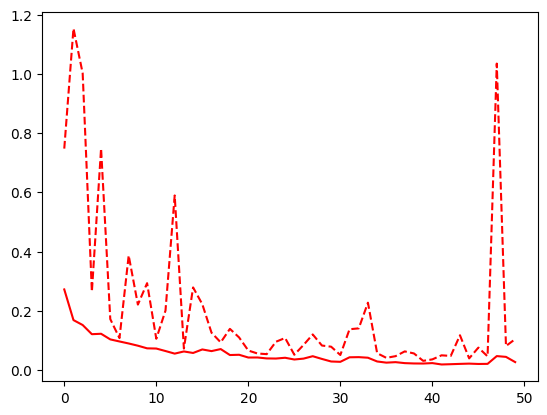

In [ ]:
plt.plot(history_seg.history['loss'], 'r-', label='Train Loss')
plt.plot(history_seg.history['val_loss'], 'r--', label='Val Loss')
plt.show()

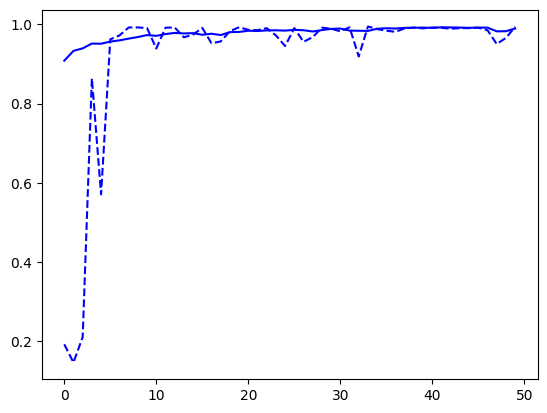

In [ ]:
plt.plot(history_seg.history['binary_accuracy'], 'b-', label='Train Accuracy')
plt.plot(history_seg.history['val_binary_accuracy'], 'b--', label='Val Accuracy')
plt.show()

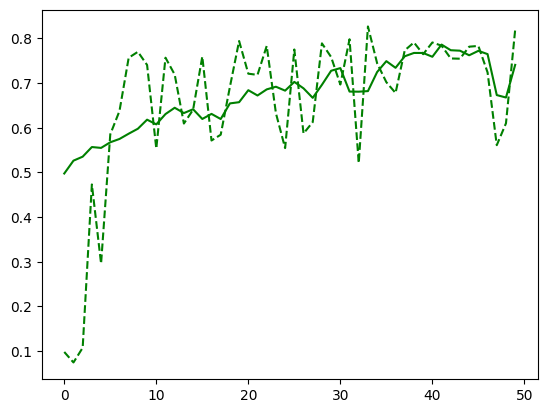

In [ ]:
plt.plot(history_seg.history['binary_io_u'], 'g-', label='Train IoU')
plt.plot(history_seg.history['val_binary_io_u'], 'g--', label='Val IoU')
plt.show()

In [ ]:
def f1(precision, recall):
    precision = np.array(precision)
    recall = np.array(recall)
    return 2 * (precision * recall) / (precision + recall)

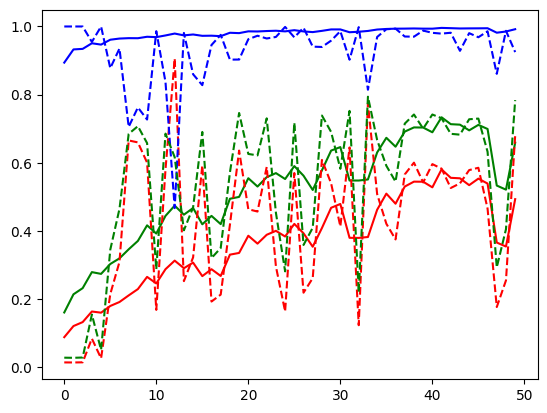

In [ ]:
plt.plot(history_seg.history['precision'], 'r-', label='Train Precision')
plt.plot(history_seg.history['recall'], 'b-', label='Train Recall')
plt.plot(f1(history_seg.history['precision'], history_seg.history['recall']), 'g-', label='Train F1')
plt.plot(history_seg.history['val_precision'], 'r--', label='Val Precision')
plt.plot(history_seg.history['val_recall'], 'b--', label='Val Recall')
plt.plot(f1(history_seg.history['val_precision'], history_seg.history['val_recall']), 'g--', label='Val F1')
plt.show()

Validation set

In [ ]:
imgs, labs, wgts = next(iter(val_datagen_seg))
preds = model_seg.predict(imgs)
preds = 1 / (1+np.exp(-preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


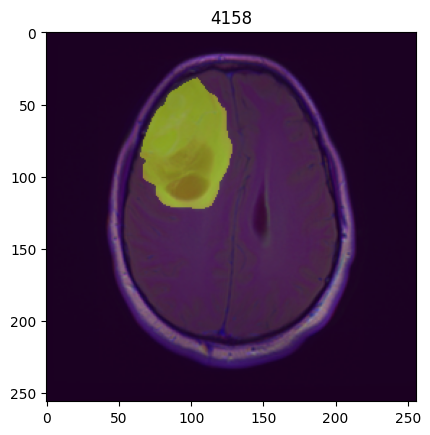

In [ ]:
i = 0
plt.imshow(imgs[i])
plt.imshow(labs[i], alpha=0.4)
plt.title(labs[i].sum())
plt.show()

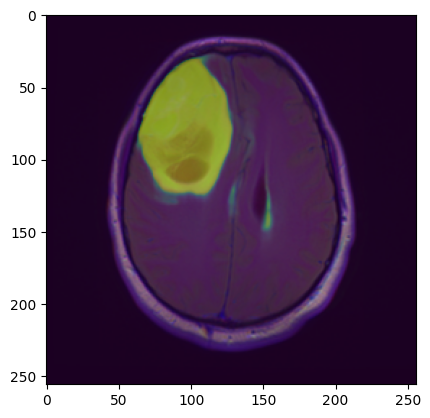

In [ ]:
i = 0
plt.imshow(imgs[i])
plt.imshow(preds[i], alpha=0.4)
plt.show()

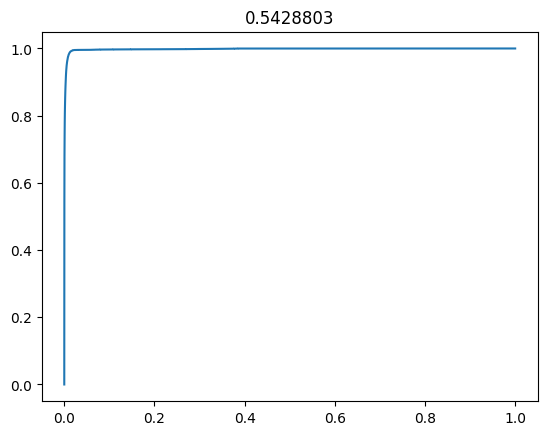

In [ ]:
fpr, tpr, thresholds = roc_curve(labs.flatten(), preds.flatten())
thresh_seg = thresholds[((fpr-0)**2 + (tpr-1)**2).argmin()]
plt.plot(fpr, tpr)
plt.title(thresh_seg)
plt.show()

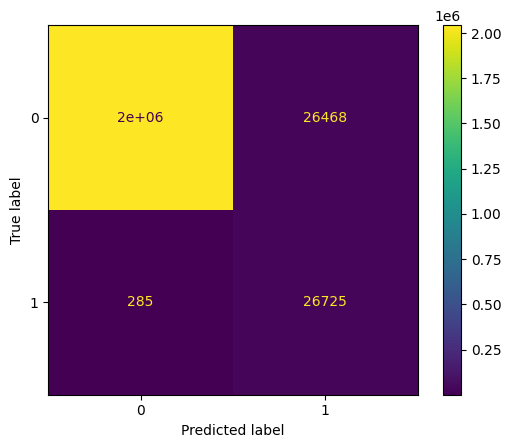

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true=labs.flatten(), y_pred=preds.flatten()>thresh_seg);

Test/holdout set

In [ ]:
imgs, labs, wgts = next(iter(test_datagen_seg))
preds = model_seg.predict(imgs)
preds = 1 / (1+np.exp(-preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


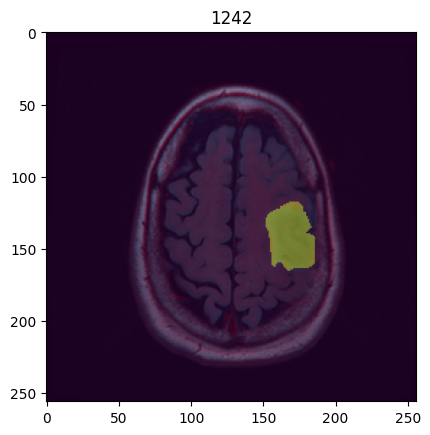

In [ ]:
i = 0
plt.imshow(imgs[i])
plt.imshow(labs[i], alpha=0.4)
plt.title(labs[i].sum())
plt.show()

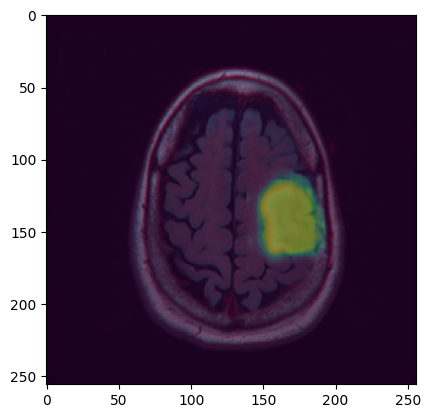

In [ ]:
i = 0
plt.imshow(imgs[i])
plt.imshow(preds[i], alpha=0.4)
plt.show()

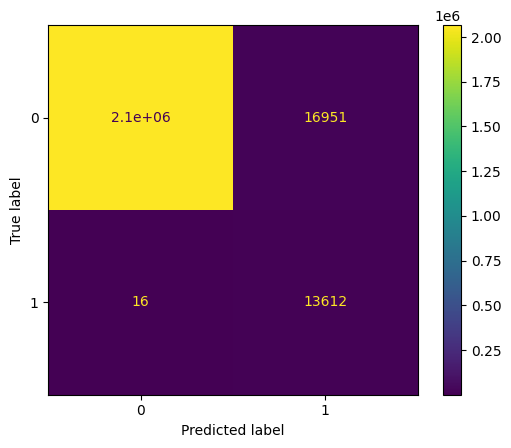

In [ ]:
thresh = 0.8
ConfusionMatrixDisplay.from_predictions(y_true=labs.flatten(), y_pred=preds.flatten()>thresh_seg);

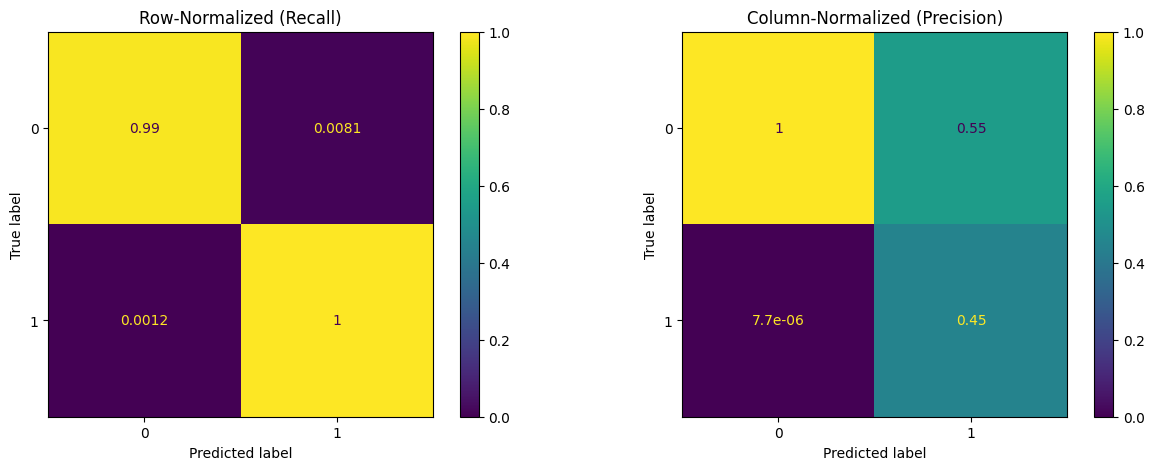

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ConfusionMatrixDisplay.from_predictions(
    y_true=labs.flatten(), y_pred=preds.flatten()>thresh_seg,
    im_kw=dict(vmin=0, vmax=1),
    ax=axes[0], normalize='true')
axes[0].set_title('Row-Normalized (Recall)')
ConfusionMatrixDisplay.from_predictions(
    y_true=labs.flatten(), y_pred=preds.flatten()>thresh_seg,
    im_kw=dict(vmin=0, vmax=1),
    ax=axes[1], normalize='pred')
axes[1].set_title('Column-Normalized (Precision)')
plt.show()
del fig, axes, thresh

---